## Logistic Regression on Cifar10 Dataset


In [127]:
import torch
import torch.nn as  nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import functional as F

In [128]:
#downloading dataset
dataset=CIFAR10(root="data/" , download=True,transform=transforms.ToTensor())
test_dataset=CIFAR10(root="data/", train=False,transform=transforms.ToTensor())

In [129]:
print(len(dataset))

50000


In [130]:
print(len(test_dataset))

10000


In [131]:
#splitting into train and validation set
train_ds,val_ds=random_split(dataset,[40000,10000])


In [132]:
print(len(train_ds))
print(len(val_ds))

40000
10000


In [133]:
print(train_ds[0])

(tensor([[[0.9961, 0.9843, 0.9961,  ..., 0.9922, 0.9922, 0.9882],
         [0.9765, 0.9647, 0.9843,  ..., 0.9765, 0.9804, 0.9765],
         [0.9725, 0.9647, 0.9882,  ..., 0.9725, 0.9725, 0.9765],
         ...,
         [0.3294, 0.3608, 0.3490,  ..., 0.1373, 0.2471, 0.3490],
         [0.3490, 0.3569, 0.3490,  ..., 0.2353, 0.2980, 0.3176],
         [0.3686, 0.3529, 0.3686,  ..., 0.3412, 0.3098, 0.3333]],

        [[1.0000, 0.9882, 0.9961,  ..., 1.0000, 0.9961, 0.9922],
         [0.9804, 0.9686, 0.9843,  ..., 0.9804, 0.9843, 0.9804],
         [0.9765, 0.9686, 0.9882,  ..., 0.9804, 0.9765, 0.9804],
         ...,
         [0.4745, 0.4980, 0.4784,  ..., 0.1647, 0.2392, 0.4275],
         [0.4902, 0.5020, 0.4980,  ..., 0.3059, 0.3725, 0.4314],
         [0.5020, 0.4980, 0.5216,  ..., 0.4549, 0.4353, 0.4627]],

        [[1.0000, 0.9961, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [0.9882, 0.9765, 0.9882,  ..., 0.9804, 0.9882, 0.9882],
         [0.9843, 0.9765, 0.9922,  ..., 0.9765, 0.9843, 0

In [134]:
#create dataloader for training and validation data
batchsize=128
train_dl=DataLoader(train_ds,batch_size=batchsize,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=batchsize)

torch.Size([3, 32, 32])
tensor(9)


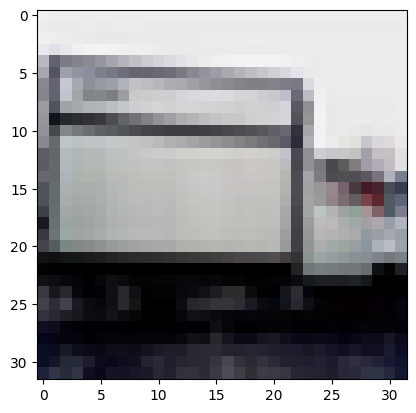

In [135]:
for images,labels in train_dl:
    plt.imshow(images[0].permute(1,2,0))
    print(images[0].shape)
    print(labels[0])
    break

In [136]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [137]:
# Create a mnist model
input_size=3*32*32
target_size=len(dataset.classes)
class CIFAR_Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(input_size,target_size)
    def forward(self,xb):
        xb=xb.reshape(-1,3*32*32)
        output=self.linear(xb)
        return output
    def train_step(self,batch):
        images,labels=batch
        pred=self(images)
        loss=F.cross_entropy(pred,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        pred=self(images)
        loss=F.cross_entropy(pred,labels)
        acc=accuracy(pred,labels)
        return {"val_loss":loss,"val_acc":acc}
    def validation_epoch_end(self,outputs):
        accs=[x["val_acc"] for x in outputs]
        loss=[x["val_loss"] for x in outputs]
        avg_acc=torch.stack(accs).mean()
        avg_loss=torch.stack(loss).mean()
        return {"val_acc":avg_acc.item(),"val_loss":avg_loss.item()}
    def epoch_end(self,epoch,result,loss):
        print("epoch:[{}]-- train_loss:{:.4f} --validation_loss:{:.4f} --validation_accuracy:{:.4f}".format(epoch,loss,result["val_loss"],result["val_acc"]))
model=CIFAR_Model()
        
        

In [138]:
def fit(epochs,lr,model,train_dl,val_dl,opt_fn=torch.optim.SGD):
    opt=opt_fn(model.parameters(),lr=lr)
    history=[]
    for epoch in range(epochs):
        loss=0
        for batch in train_dl:
            loss=model.train_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
        result=evaluate(model,val_dl)
        model.epoch_end(epoch,result,loss)
        history.append(result["val_loss"])
    return history
        
            

In [139]:
def evaluate(model,val_dl):
    outputs=[model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)
def accuracy(pred,labels):
    _,pred=torch.max(pred,dim=1)
    return torch.tensor(torch.sum((pred==labels))/len(labels))

In [140]:
hist1=fit(5,0.001,model,train_dl,val_dl)

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_13844\2749660665.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((pred==labels))/len(labels))


epoch:[0]-- train_loss:2.1296 --validation_loss:2.1421 --validation_accuracy:0.2566
epoch:[1]-- train_loss:2.0551 --validation_loss:2.0669 --validation_accuracy:0.2821
epoch:[2]-- train_loss:1.9610 --validation_loss:2.0223 --validation_accuracy:0.3080
epoch:[3]-- train_loss:1.8601 --validation_loss:1.9923 --validation_accuracy:0.3191
epoch:[4]-- train_loss:2.0620 --validation_loss:1.9687 --validation_accuracy:0.3267


In [156]:
hist2=fit(5,0.01,model,train_dl,val_dl)

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_13844\2749660665.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((pred==labels))/len(labels))


epoch:[0]-- train_loss:1.9111 --validation_loss:1.8960 --validation_accuracy:0.3372
epoch:[1]-- train_loss:1.7785 --validation_loss:1.8592 --validation_accuracy:0.3550
epoch:[2]-- train_loss:1.8952 --validation_loss:1.8713 --validation_accuracy:0.3379
epoch:[3]-- train_loss:1.7533 --validation_loss:1.8441 --validation_accuracy:0.3552
epoch:[4]-- train_loss:1.7381 --validation_loss:1.8374 --validation_accuracy:0.3474


In [158]:
hist3=fit(5,0.001,model,train_dl,val_dl)

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_13844\2749660665.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((pred==labels))/len(labels))


epoch:[0]-- train_loss:1.6407 --validation_loss:1.8001 --validation_accuracy:0.3820
epoch:[1]-- train_loss:1.5565 --validation_loss:1.7988 --validation_accuracy:0.3833
epoch:[2]-- train_loss:1.7673 --validation_loss:1.7978 --validation_accuracy:0.3823
epoch:[3]-- train_loss:1.8960 --validation_loss:1.7978 --validation_accuracy:0.3840
epoch:[4]-- train_loss:1.5605 --validation_loss:1.7970 --validation_accuracy:0.3840


In [162]:
hist=hist1+hist2+hist3
print(len(hist))

15


Text(0.5, 1.0, 'epcohs vs loss')

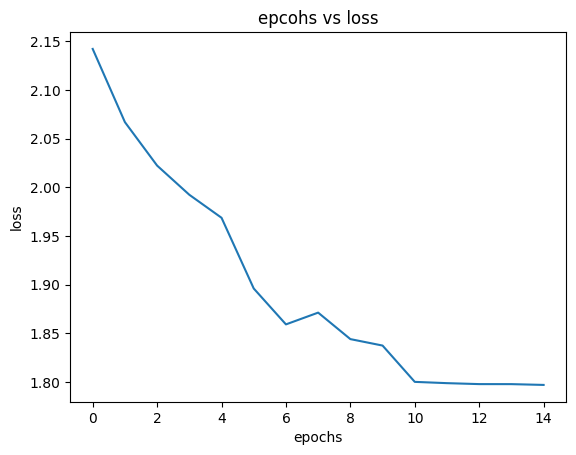

In [164]:
plt.plot(hist)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("epcohs vs loss")

In [166]:
# making predictions
def predict(xb):
    xb=torch.squeeze(xb)
    output=model(xb)
    _,pred=torch.max(output,dim=1)
    return dataset[pred]

In [168]:
test_dl=DataLoader(test_dataset,batch_size=256,shuffle=True)

In [170]:
evaluate(model,test_dl)

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_13844\2749660665.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((pred==labels))/len(labels))


{'val_acc': 0.38525390625, 'val_loss': 1.7791715860366821}

In [ ]:
for images,labels in test_dl:
    